In [87]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 13 2024
@author: Ishaan Shah (phw6bv)
"""
import scipy
import numpy as np
import pandas as pd
import NetfluxODE_params as params
import NetfluxODE as file
import matplotlib.pyplot as plt
import networkx as nx

[speciesNames, tau, ymax, y0, w, n, EC50] = params.loadParams()
print(speciesNames)
print(len(speciesNames))

y0   = np.asarray(y0, dtype=float)
tau  = np.asarray(tau, dtype=float)

#production capacity for maximum stimulation
ymax = np.asarray(ymax, dtype=float)
w    = np.asarray(w,    float)
n    = np.asarray(n, dtype=float)
EC50 = np.asarray(EC50, dtype=float)
print(ymax)

# ymax *= 0.5
# print(f"Updated ymax: {ymax}")

['PIK3CA', 'ROS', 'Rock2', 'KLF2', 'CCM3', 'MIF', 'NFkB', 'CCM1', 'MEKK3', 'MEK5', 'ERK5', 'NOTCH', 'HEY1', 'HEY2', 'TSP1', 'Thbs1', 'TGFb', 'LGALS3BP', 'GAL3', 'GAL3ACT', 'CCND1', 'MMP9', 'eNOS', 'NO', 'HIF1alpha', 'Ang1', 'Tie2', 'PI3k', 'Akt', 'mTORC1', 'E4BP1', 'eIF4E', 'glutamate', 'GLAST', 'GLT1', 'Cd74', 'MCP1', 'IL18', 'IL1B', 'caspase1', 'NLRP3', 'COX2', 'VEGF', 'GLEXC', 'ANG', 'INFL', 'ASTRPROF', 'HEM']
48
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Steady State before CCM

In [91]:
#40 time units that displays the activity of each gene before any perturbation in a normal interaction

tspan = [0.0, 40.0] 
t_eval = np.linspace(tspan[0], tspan[1], 401)

sol_dict = {}
t_list = []
y_list = []

# sol = scipy.integrate.solve_ivp(file.ODEfunc,tspan,y0,args=(tau,ymax,w,n,EC50,))

sol = scipy.integrate.solve_ivp(
    file.ODEfunc,
    tspan,
    y0,
    args=(tau, ymax, w, n, EC50),
    # method="BDF",               # better for stiff systems
    atol=1e-8, rtol=1e-6,       # tighter tolerances
    t_eval=t_eval,              # fixed grid for plotting, although calculation is adaptive inside ode
    max_step=1.0               
)


# sol_dict[1] = sol
# t_list.append(sol.t)
# y_list.append(sol.y)

# #combines arrays into a single list or relative lists
# t = np.hstack(t_list)
# y = np.hstack(y_list)

# #turns y into a timepoints vector by row
# y_plot = y.T
y_plot = sol.y
t = sol.t
ss = y_plot[:, -1] # steady state
print(ss)
# print(ymax)

#make sure its settled near steady state
window = max(2, y_plot.shape[1] // 10)  # last 10% of trajectory
delta  = np.max(np.abs(y_plot[:, -1] - y_plot[:, -window]))
if delta > 1e-4:
    print(f"Warn: Δ={delta:.2e}, extend tspan.")


[0.3        0.3        0.3        0.3        0.3        0.3
 0.3        0.3        0.24444689 0.18849092 0.13433637 0.24444689
 0.18849092 0.18849092 0.18849092 0.24444689 0.34594516 0.79993948
 0.24444689 0.13861479 0.08917416 0.08917416 0.8192516  0.75223351
 0.87528997 0.65555311 0.60328276 0.91061332 0.82913708 0.76077341
 0.70063377 0.6456775  0.76652736 0.24444689 0.77381291 0.24444689
 0.92565963 0.32417847 0.68213811 0.37749701 0.42913951 0.83764907
 0.85574361 0.70579182 0.96237254 0.99000943 0.04895866 0.04895866]


## Steady State after Endothelial Cell Interactions

In [71]:
# #new steady state based on start of CCM from endothelial cells

# #go through each input manually since they could go either way

# #KLF2
# ymax[0] = 0.75

# #ROS
# ymax[1] = 0.75

# #PIK3CA
# ymax[2] = 0.75

# #CCM3
# ymax[3] = 0

# #Rock2
# ymax[4] = 0.75

# #MIF
# ymax[5] = 0.75

# #NFkB
# ymax[6] = 0.75

# #CCM1
# ymax[7] = 0

# tspan = [0, 40] 

# sol_dict = {}
# t_list = []
# y_list = []

# sol = scipy.integrate.solve_ivp(file.ODEfunc,tspan,y0,args=(tau,ymax,w,n,EC50,))
# sol_dict[1] = sol
# t_list.append(sol.t)
# y_list.append(sol.y)

# t = np.hstack(t_list)
# y = np.hstack(y_list)

# y_plot = y.T

# ss = y_plot[-1,:] # steady state
# print(ss)
# print(ymax)

## Find the effects of each gene on a target symptom (Mechanistic Analysis)

Knockdown each gene individually and compare its new activity with that of the steady state. This block keeps track of the changes upon a certain chosen symptom based on each knockdown. 

In [ ]:
#first middle and output node in the network 
first_middle = 8
first_output = 43 #check netflux ODE for this (make sure you update)

def gene_effect_on_symptom(symptom):
    #keep track of each gene's effect on the symptom in question
    change_in_symptom = {}
    num_species = len(speciesNames)

    #loop through all genes
    for i in range(0, num_species):
        # Copy ymax and set the current biomolecule's ymax to 0 (simulate knockdown)
        #print(speciesNames[i])
        ymax_knockdown = ymax.copy()
        ymax_knockdown[i] = 0

        # Run the simulation with the knockdown
        sol2_dict = {}
        t2_list = []
        y2_list = []
        sol2 = scipy.integrate.solve_ivp(file.ODEfunc,tspan,y0,args=(tau,ymax_knockdown,w,n,EC50,))
        sol2_dict[1] = sol2
        t2_list.append(sol2.t)
        y2_list.append(sol2.y)

        t2 = np.hstack(t2_list)
        y2 = np.hstack(y2_list)

        y2_plot = y2.T

        ss_pertubation = y2_plot[-1,:]  # steady-state values at the end of the simulation

        # Calculate the change in activity for the tracked biomolecule due to the knockdown
        change_in_activity = ss_pertubation[symptom] - ss[symptom]

        # Store the result in the dictionary with the gene name as the key
        #stop at the first output, to not key in the outputs
        if i >= first_output: #change this later to be more efficient, cuz calc not needed
            change_in_symptom[speciesNames[i]] = 0
        else:
            change_in_symptom[speciesNames[i]] = change_in_activity

    sorted_change = dict(sorted(change_in_symptom.items(), key=lambda item: item[1]))
    return sorted_change    

In [73]:
def plot_change(sorted_change, symptom, symptom_name):
    sorted_change_df = pd.DataFrame(list(sorted_change.items()), columns=['Symptom', 'Change in Activity of Symptom'])
    # print(sorted_change_df)

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_change_df['Symptom'], sorted_change_df['Change in Activity of Symptom'])
    plt.xticks(rotation=90)
    plt.xlabel(f'{symptom_name}')
    plt.ylabel(f'Change in Activity of {symptom_name}')
    plt.title(f'Change in Activity of {speciesNames[symptom]} across Knockdowns')
    plt.tight_layout()
    plt.show()

## Important files

In [74]:
#UNIFORM COST SEARCH
#get the model Excel and retrieve all the species for nodes, and reactions for edges

networkName = "CCMNetIS.xlsx"  #network excel
species_sheet = "species" #sheet in the excel
reaction_sheet = "reactions" #another sheet in the excel

species_df = pd.read_excel(networkName, sheet_name = species_sheet, header = 1)
reactions_df = pd.read_excel(networkName, sheet_name = reaction_sheet, header = 1)

# Inspect the first few rows to ensure it's loaded correctly
print(species_df.head())

   module      ID                              name  Yinit  Ymax  tau  \
0  inputs  PIK3CA                            PIK3CA      0     1    1   
1  inputs     ROS           Reactive Oxygen Species      0     1    1   
2  inputs   Rock2                      Angiogenesis      0     1    1   
3  inputs    KLF2  Kruppel like trancription factor      0     1    1   
4  inputs    CCM3                              CCM3      0     1    1   

            type  location Gene Name  \
0        protein       NaN    PIK3CA   
1  smallMolecule       NaN       ROS   
2        protein       NaN     Rock2   
3        protein       NaN      KLF2   
4        protein       NaN       NaN   

                                            Function  \
0                                 Cell proliferation   
1     Free radicals reacting with stuff it shouldn't   
2  Mutation in CCM, which usuallly inactivates Rh...   
3  regulation of monocytes and endothelial cells,...   
4                              Mutation 

In [75]:
#show that it displays what you want(reactions in this case)
reactions_df.drop([0], inplace=True)
print(reactions_df.head())

   module  ID       Rule  Weight    n  EC50  confidence 1  species 1 Mutation  \
1  inputs  i1    => KLF2     0.3  1.4   0.5           NaN        NaN     CCM3   
2  inputs  i2     => ROS     0.3  1.4   0.5           NaN        NaN     CCM3   
3  inputs  i3  => PIK3CA     0.3  1.4   0.5           NaN        NaN  its own   
4  inputs  i4    => CCM3     0.3  1.4   0.5           NaN        NaN     CCM3   
5  inputs  i5   => Rock2     0.3  1.4   0.5           NaN        NaN  All CCM   

  Initial Change  ... database 1 ref ID 1  \
1    Upregulated  ...        NaN      NaN   
2    upregulated  ...        NaN      NaN   
3    Upregulated  ...        NaN      NaN   
4    Knocked out  ...        NaN      NaN   
5    upregulated  ...        NaN      NaN   

                                              link 1  \
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8...   
2  https://www.ahajournals.org/doi/10.1161/CIRCRE...   
3  https://www.sciencedirect.com/science/article/...   
4  https://www.sci

## Make the network in python

In [76]:
#makes and displays the signaling network
def make_signaling_network(reactions_df, sorted_change):
    signaling_network = nx.DiGraph()

    for index, row in reactions_df.iterrows():
        #inputs dont need to be added individually to the network as they dont have a reaction, product pair
        if row['module'] == 'inputs':
            continue
        else:
            #grab the reaction column with =>
            reaction = row['Rule'] 
            # print(reaction)

            # Ensure reactants are initialized
            reactants = []

            # Split the reaction string by the arrow to get the reactant and product
            if '=>' in reaction:
                reactant_part, product = reaction.split('=>')         
                
                reactants = [r.strip().strip("!") for r in reactant_part.split('&')]
                product = product.strip().strip("!")
                # print(reactant, product)

                # Add the edge from the reactant to the product to the signaling network
                for reactant in reactants:
                    signaling_network.add_edge(reactant, product)
    #sorted_change is a sorted dictionary for changes in activity for a symptom while each node is knocked down

    # Add costs to edges by taking average effect of product and reactant on symptom
    for (reactant, product) in signaling_network.edges:
        reactant_cost = sorted_change[reactant]
        product_cost = sorted_change[product]
        # print(reactant_cost)
        # print(product_cost)
        cost = (reactant_cost + product_cost)/2
        # if product == 'ANG':
        #     cost = reactant_cost
        # print(cost)
        signaling_network[reactant][product]['cost'] = cost

    # Verify by printing edges with costs
    # print("Edge Costs:")
    # for u, v, data in signaling_network.edges(data=True):
    #     print(f"({u} -> {v}): {data}")
    return signaling_network
# ANG_signaling_network = make_signaling_network(reactions_df, ANG_sorted_change)
# GLEXC_signaling_network = make_signaling_network(reactions_df, GLEXC_sorted_change)
# print("Edges in the graph:")
# print(list(GLEXC_signaling_network.edges))


In [77]:
#displays the network
def display_network(signaling_network):
    plt.figure(figsize=(10, 8))
    nx.draw(signaling_network, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold', arrowstyle="->", arrowsize=15)
    plt.title("Species Reaction Network")
    plt.show()

## Uniform Cost Search

In [78]:
#actual uniform cost search based on path that decreases angiogenesis the most

#Starts at source and ends at target
#finds shortest path by keeping track of cumulative changes to angiogenesis
#networkx uses a similar algorithm taking cost into account (default is djikstra)
#bell man ford used since there are negative weights

#function to run shortest path with negative cycles accounted for
def find_best_treatment_path(signaling_network, source, target, weight):
    try:
        # Check for negative weight cycles in the graph
        if nx.negative_edge_cycle(signaling_network, weight):
            print("Graph contains a negative weight cycle.")
            
            # Modified Bellman-Ford to account for cycles
            visited = set()
            def custom_bellman_ford(signaling_network, source, target, weight):
                path = []
                current_gene = source
                while current_gene not in visited:
                    visited.add(current_gene)
                    path.append(current_gene)
                    # Get neighbors and their weights
                    neighbors = signaling_network[current_gene]
                    next_gene, min_cost = None, float('inf')
                    for neighbor, edge in neighbors.items():
                        if neighbor in visited:
                            continue  # Skip visited nodes
                        edge_cost = edge.get(weight, float('inf'))
                        if edge_cost < min_cost:
                            next_gene, min_cost = neighbor, edge_cost
                    if next_gene is None or current_gene == target:
                        break  # Stop if no further path or target reached
                    current_gene = next_gene
                if target not in path:
                    raise nx.NetworkXNoPath(f"No path from {source} to {target}")
                return path

            path = custom_bellman_ford(signaling_network, source, target, weight)
            path_cost = sum(signaling_network[u][v]["cost"] for u, v in zip(path[:-1], path[1:]))
        else:
            path = nx.shortest_path(signaling_network, source, target, weight, method="bellman-ford")
            print(len(path))
            path_cost = nx.shortest_path_length(signaling_network, source, target, weight, method="bellman-ford")
    except nx.NetworkXNoPath:
        print("No path found between specified nodes.")
        return None, None
    return path, path_cost

## Outputs

In [79]:
#symptoms
glutamate_excitotoxicity = 43
angiogenesis = 44
neuroinflammation = 45
astrocyte_proliferation = 46
hemorrhage = 47

## Angiogenesis

c:\Users\ishah\OneDrive\Documents\Price Lab Research\generate drug list\generate drug list\NetfluxODE.py:117: RuntimeWarning: invalid value encountered in scalar power
  fact = w*(beta*x**n)/(K**n+x**n)


{'GLEXC': 0, 'ANG': 0, 'INFL': 0, 'ASTRPROF': 0, 'HEM': 0, 'HIF1alpha': 0.45068568898521705, 'Akt': 0.5343963112321013, 'PI3k': 0.5343965066980331, 'VEGF': 0.8269561325931122, 'COX2': 0.8383235760678591, 'NO': 0.8411380154927316, 'eNOS': 0.8411381408165723, 'eIF4E': 0.9060342742534928, 'E4BP1': 0.9060883464276558, 'mTORC1': 0.9061482015914155, 'LGALS3BP': 0.9282919630685238, 'Ang1': 0.9315554289697372, 'Tie2': 0.9315554387920203, 'CCM1': 0.9473405304906969, 'NOTCH': 0.9500609123935405, 'KLF2': 0.9543151520980979, 'HEY1': 0.9568424791257844, 'HEY2': 0.9568424791257844, 'MIF': 0.957417099125433, 'Cd74': 0.9574172277220839, 'Thbs1': 0.9594045234571892, 'TSP1': 0.9594077674565293, 'PIK3CA': 0.9601419849974488, 'ROS': 0.9602997489663337, 'GAL3ACT': 0.9603016478185897, 'GAL3': 0.960302083968543, 'MEKK3': 0.960650822511191, 'MEK5': 0.9606534565613937, 'ERK5': 0.960712800628751, 'Rock2': 0.9623868135417653, 'CCND1': 0.9624263390332797, 'MMP9': 0.9624263390332797, 'GLAST': 0.9624724948160646, '

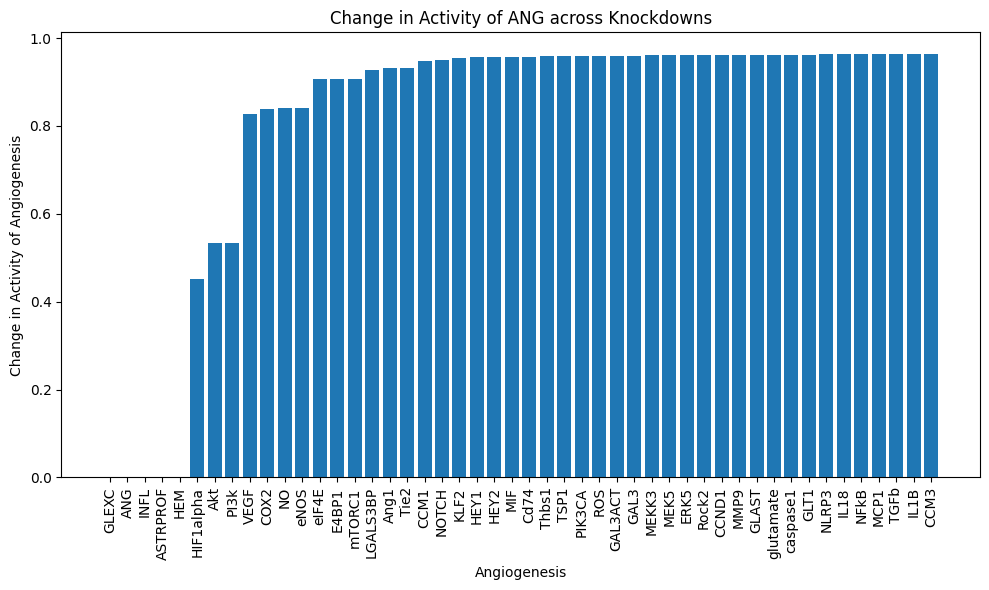

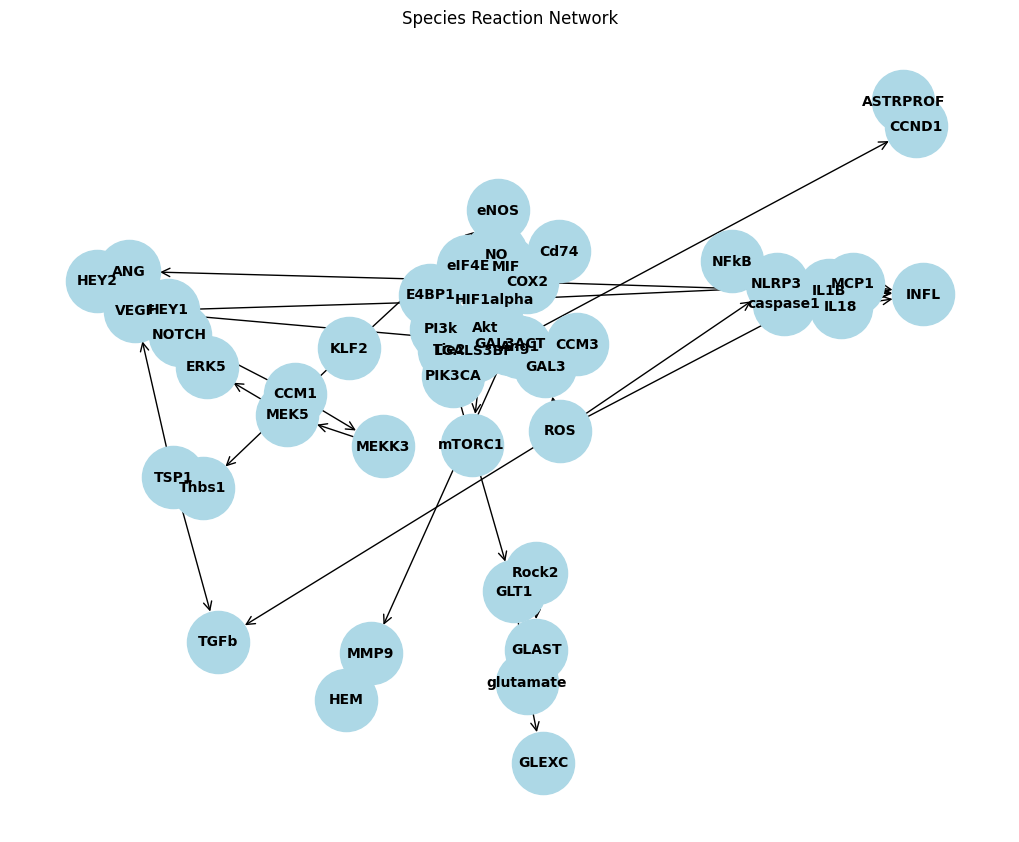

In [80]:
ANG_sorted_change = gene_effect_on_symptom(angiogenesis)
print(ANG_sorted_change)
ANG_signaling_network = make_signaling_network(reactions_df, ANG_sorted_change)
ANG_best_path, ANG_best_path_cost = find_best_treatment_path(ANG_signaling_network, source="CCM3", target="ANG", weight="cost")
print("Shortest path for Angiogenesis based on cost:", ANG_best_path)
print("Total Angiogenesis path cost:", ANG_best_path_cost)
plot_change(ANG_sorted_change, angiogenesis, "Angiogenesis")
display_network(ANG_signaling_network)

In [81]:
ang_species = ANG_sorted_change.keys()
ang_values = ANG_sorted_change.values()
ANG_sorted_change_df = pd.DataFrame(ang_values, ang_species)
print(ANG_sorted_change_df)

                  0
GLEXC      0.000000
ANG        0.000000
INFL       0.000000
ASTRPROF   0.000000
HEM        0.000000
HIF1alpha  0.450686
Akt        0.534396
PI3k       0.534397
VEGF       0.826956
COX2       0.838324
NO         0.841138
eNOS       0.841138
eIF4E      0.906034
E4BP1      0.906088
mTORC1     0.906148
LGALS3BP   0.928292
Ang1       0.931555
Tie2       0.931555
CCM1       0.947341
NOTCH      0.950061
KLF2       0.954315
HEY1       0.956842
HEY2       0.956842
MIF        0.957417
Cd74       0.957417
Thbs1      0.959405
TSP1       0.959408
PIK3CA     0.960142
ROS        0.960300
GAL3ACT    0.960302
GAL3       0.960302
MEKK3      0.960651
MEK5       0.960653
ERK5       0.960713
Rock2      0.962387
CCND1      0.962426
MMP9       0.962426
GLAST      0.962472
glutamate  0.962539
caspase1   0.962575
GLT1       0.962596
NLRP3      0.962622
IL18       0.962656
NFkB       0.962670
MCP1       0.962684
TGFb       0.962704
IL1B       0.962705
CCM3       0.964820


## Glutamate Excitotoxicity

c:\Users\ishah\OneDrive\Documents\Price Lab Research\generate drug list\generate drug list\NetfluxODE.py:117: RuntimeWarning: invalid value encountered in scalar power
  fact = w*(beta*x**n)/(K**n+x**n)


9
Shortest path for Glutamate Excitotoxicity based on cost: ['CCM3', 'Ang1', 'Tie2', 'PI3k', 'Akt', 'mTORC1', 'GLT1', 'glutamate', 'GLEXC']
Total Glutamate Excitotoxicity path cost: 2.5866102419234602


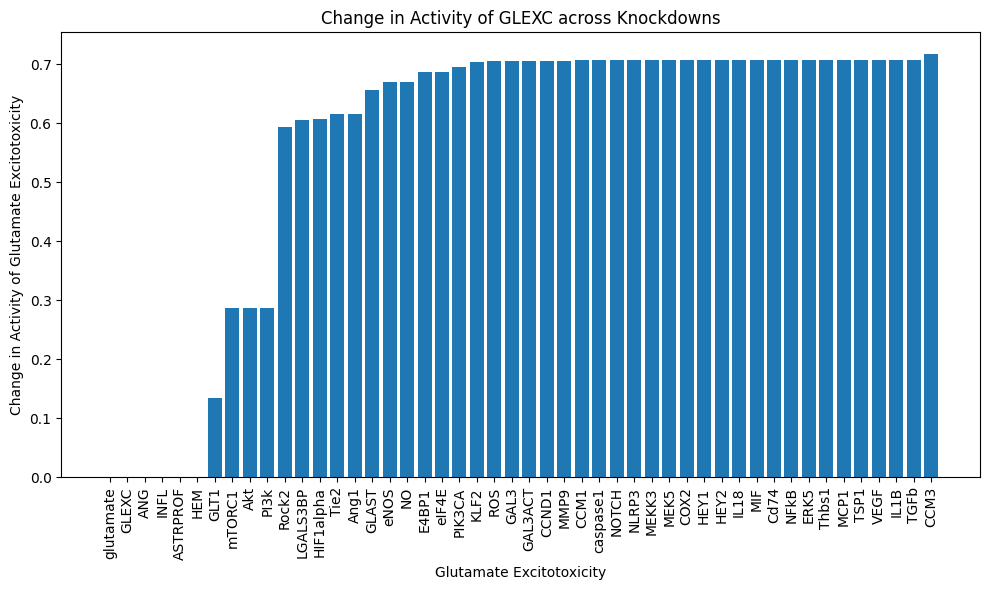

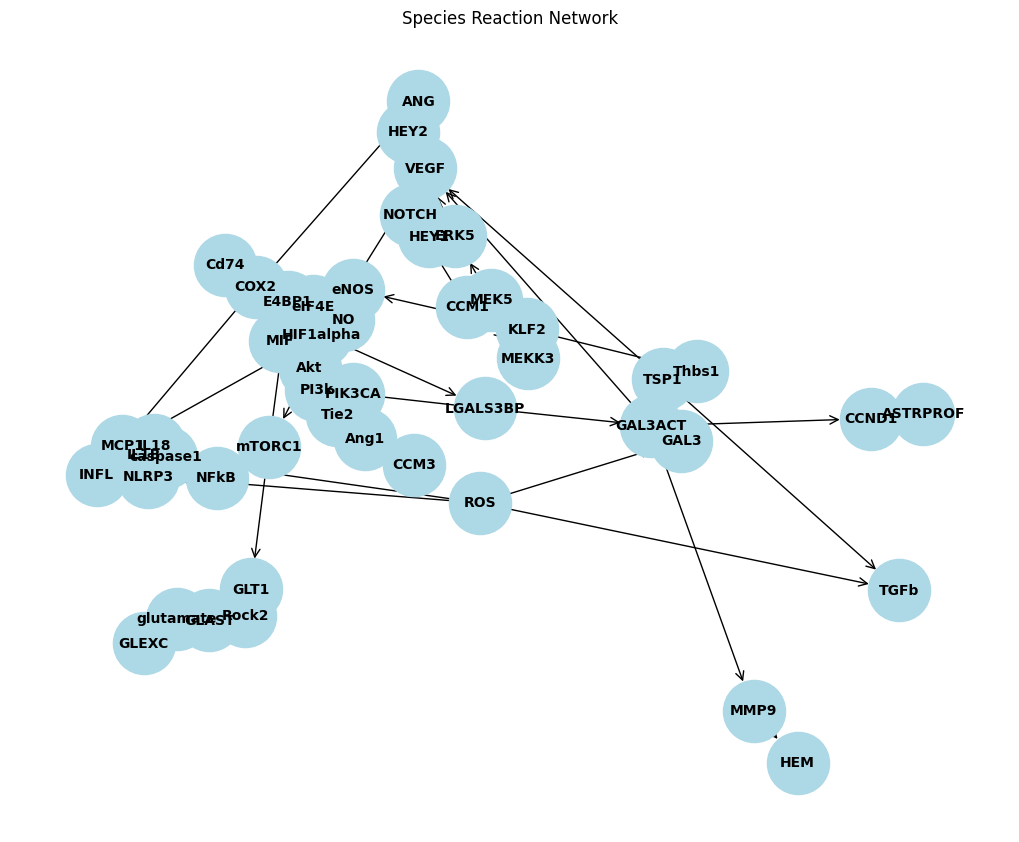

In [82]:
GLEXC_sorted_change = gene_effect_on_symptom(glutamate_excitotoxicity)
GLEXC_signaling_network = make_signaling_network(reactions_df, GLEXC_sorted_change)
GLEXC_best_path, GLEXC_best_path_cost = find_best_treatment_path(GLEXC_signaling_network, source="CCM3", target="GLEXC", weight="cost")
print("Shortest path for Glutamate Excitotoxicity based on cost:", GLEXC_best_path)
print("Total Glutamate Excitotoxicity path cost:", GLEXC_best_path_cost)
plot_change(GLEXC_sorted_change, glutamate_excitotoxicity, "Glutamate Excitotoxicity")
display_network(GLEXC_signaling_network)

## Neuroinflammation

10
Shortest path for Neuroinflammation based on cost: ['CCM3', 'Ang1', 'Tie2', 'PI3k', 'Akt', 'eNOS', 'NO', 'HIF1alpha', 'MCP1', 'INFL']
Total Neuroinflammation path cost: 8.06340985572865


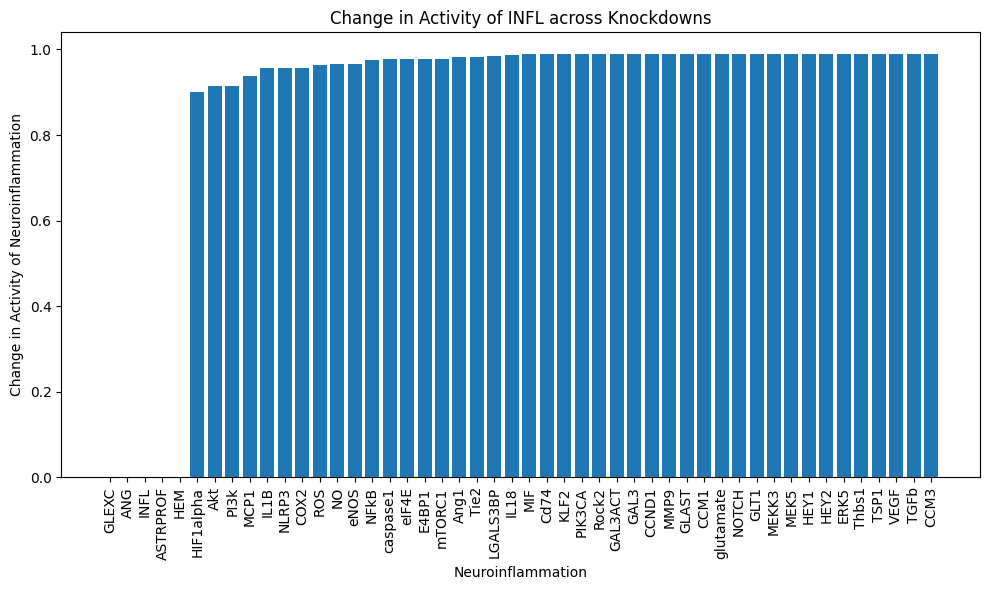

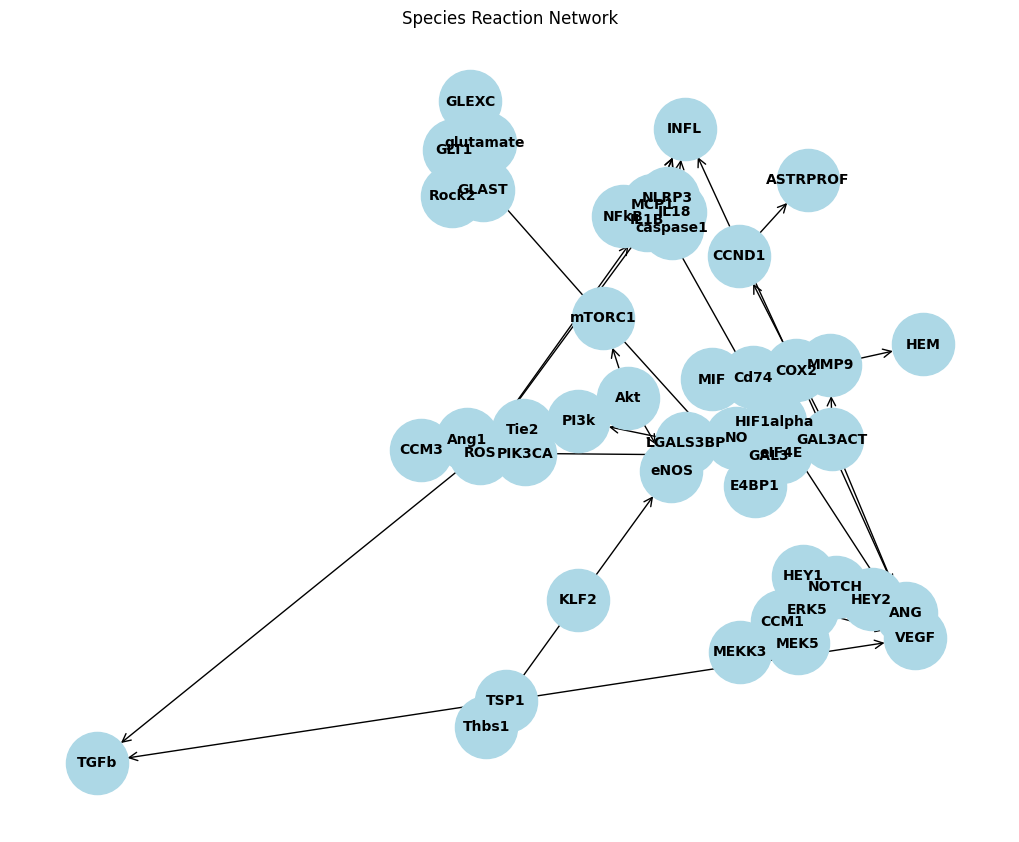

In [83]:
INFL_sorted_change = gene_effect_on_symptom(neuroinflammation)
INFL_signaling_network = make_signaling_network(reactions_df, INFL_sorted_change)
INFL_best_path, INFL_best_path_cost = find_best_treatment_path(INFL_signaling_network, source="CCM3", target="INFL", weight="cost")
print("Shortest path for Neuroinflammation based on cost:", INFL_best_path)
print("Total Neuroinflammation path cost:", INFL_best_path_cost)
plot_change(INFL_sorted_change, neuroinflammation, "Neuroinflammation")
display_network(INFL_signaling_network)

## Astrocyte Proliferation

12
Shortest path for Astrocyte Proliferation based on cost: ['CCM3', 'Ang1', 'Tie2', 'PI3k', 'Akt', 'eNOS', 'NO', 'HIF1alpha', 'LGALS3BP', 'GAL3ACT', 'CCND1', 'ASTRPROF']
Total Astrocyte Proliferation path cost: 0.1308744579477944


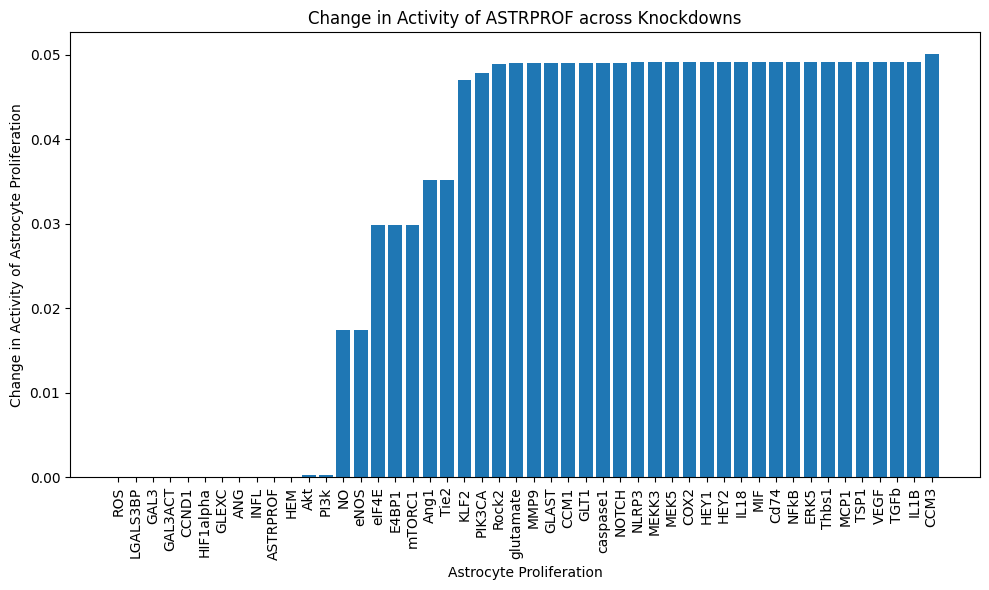

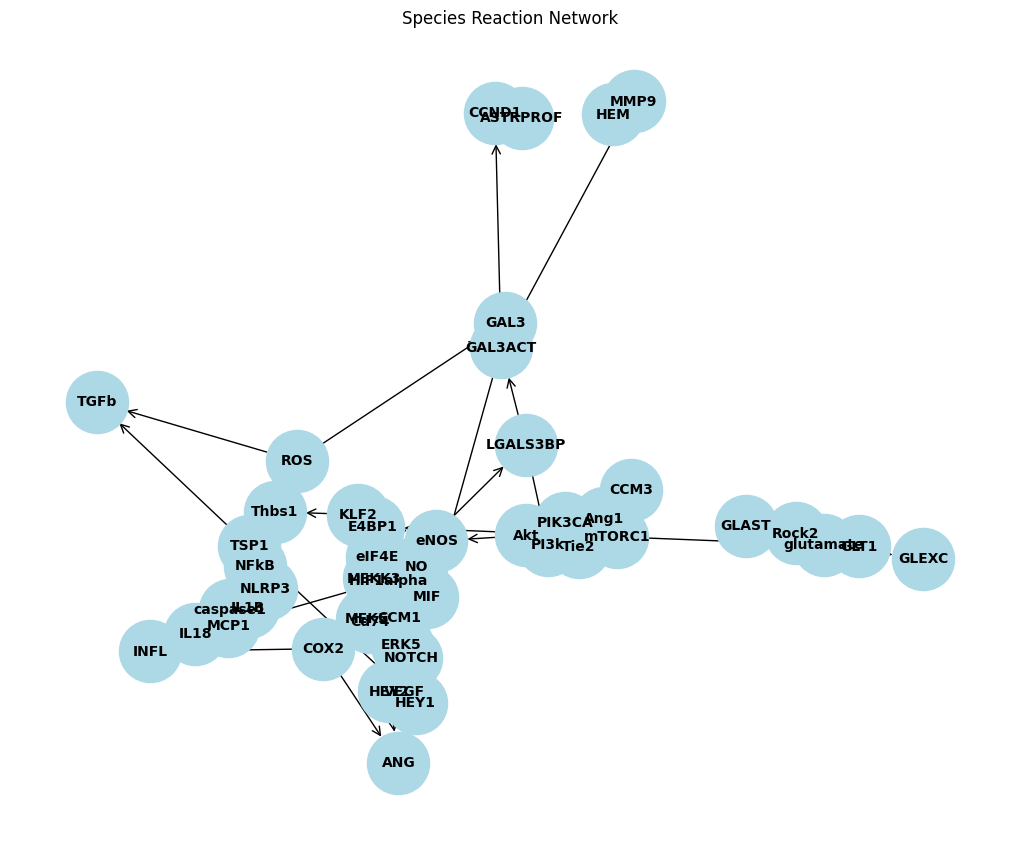

In [84]:
ASTRPROF_sorted_change = gene_effect_on_symptom(astrocyte_proliferation)
ASTRPROF_signaling_network = make_signaling_network(reactions_df, ASTRPROF_sorted_change)
ASTRPROF_best_path, ASTRPROF_best_path_cost = find_best_treatment_path(ASTRPROF_signaling_network, source="CCM3", target="ASTRPROF", weight="cost")
print("Shortest path for Astrocyte Proliferation based on cost:", ASTRPROF_best_path)
print("Total Astrocyte Proliferation path cost:", ASTRPROF_best_path_cost)
plot_change(ASTRPROF_sorted_change, astrocyte_proliferation, "Astrocyte Proliferation")
display_network(ASTRPROF_signaling_network)

## Hemorrhage

12
Shortest path for Hemorrhage based on cost: ['CCM3', 'Ang1', 'Tie2', 'PI3k', 'Akt', 'eNOS', 'NO', 'HIF1alpha', 'LGALS3BP', 'GAL3ACT', 'MMP9', 'HEM']
Total Hemorrhage path cost: 0.1308739322014694


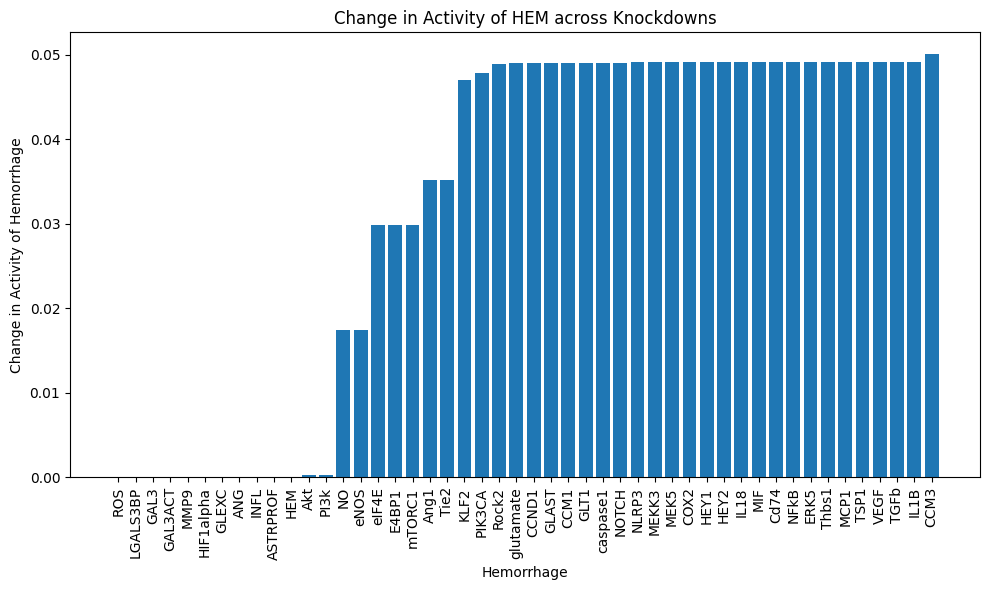

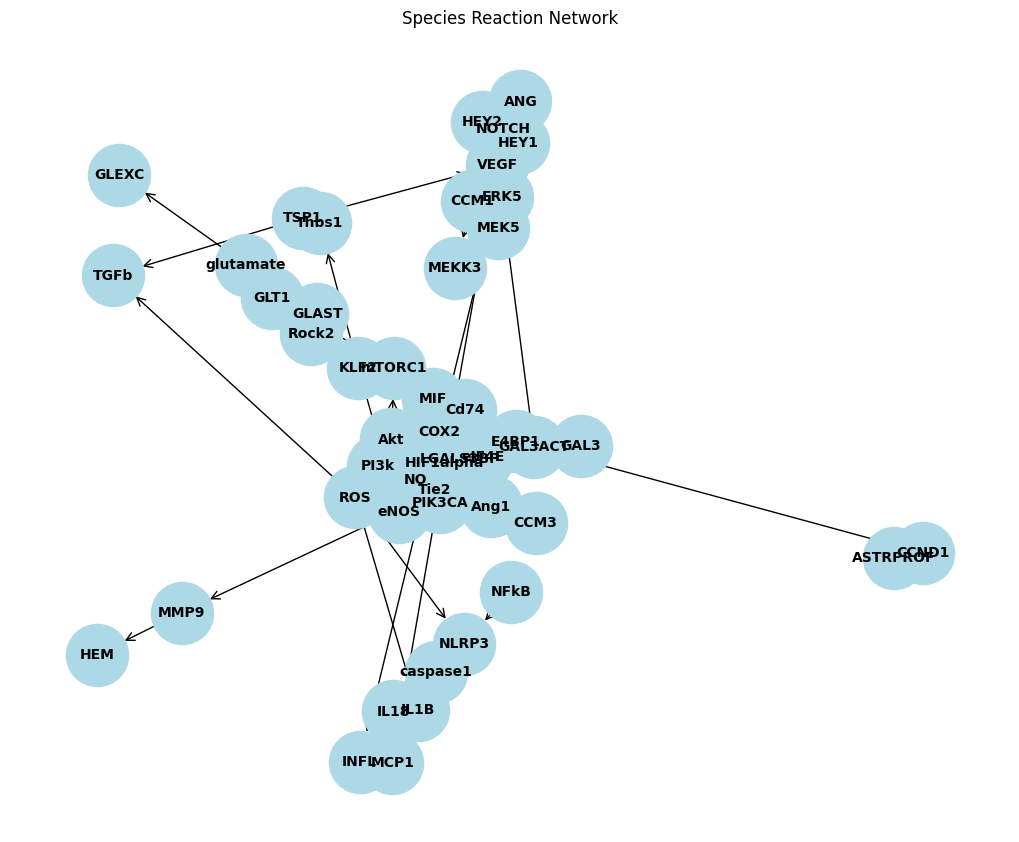

In [85]:
HEM_sorted_change = gene_effect_on_symptom(hemorrhage)
HEM_signaling_network = make_signaling_network(reactions_df, HEM_sorted_change)
HEM_best_path, HEM_best_path_cost = find_best_treatment_path(HEM_signaling_network, source="CCM3", target="HEM", weight="cost")
print("Shortest path for Hemorrhage based on cost:", HEM_best_path)
print("Total Hemorrhage path cost:", HEM_best_path_cost)
plot_change(HEM_sorted_change, hemorrhage, "Hemorrhage")
display_network(HEM_signaling_network)

Change validation to have increases and decreases
    -make validation figure

find more nodes for astrprof

further investigate common pathways seen as most efficient (expand it)

change source from CCM3
